In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sunxin/minico

1.13.2
2.2.4


Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist
from keras import layers
from keras import models
from keras import losses
from keras import backend as K

In [3]:
# reparameterization trick
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [4]:
# MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

image_size = X_train.shape[1]
original_dim = image_size * image_size
X_train = np.reshape(X_train, [-1, original_dim])
X_test = np.reshape(X_test, [-1, original_dim])
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

In [5]:
# VAE model = encoder + decoder
# build encoder model
inputs = layers.Input(shape=input_shape, name='encoder_layers.Input')
x = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as layers.Input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = models.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = models.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = models.Model(inputs, outputs, name='vae_mlp')

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_layers.Input (InputLaye (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_layers.Input[0][0]       
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
_____________________________________

In [6]:
reconstruction_loss = losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_layers.Input (InputL (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


In [7]:
vae.fit(X_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, None))
vae.save_weights('vae_mlp_mnist.h5')

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 58us/step - loss: 197.3936 - val_loss: 172.4063
Epoch 2/50
60000/60000 [==============================] - 2s 31us/step - loss: 170.1538 - val_loss: 166.7561
Epoch 3/50
60000/60000 [==============================] - 2s 31us/step - loss: 165.7106 - val_loss: 164.1572
Epoch 4/50
60000/60000 [==============================] - 2s 31us/step - loss: 163.3752 - val_loss: 162.3365
Epoch 5/50
60000/60000 [==============================] - 2s 32us/step - loss: 161.9457 - val_loss: 161.3490
Epoch 6/50
60000/60000 [==============================] - 2s 33us/step - loss: 160.7243 - val_loss: 160.4094
Epoch 7/50
60000/60000 [==============================] - 2s 31us/step - loss: 159.6293 - val_loss: 159.3106
Epoch 8/50
60000/60000 [==============================] - 2s 31us/step - loss: 158.4840 - val_loss: 158.2389
Epoch 9/50
60000/60000 [======

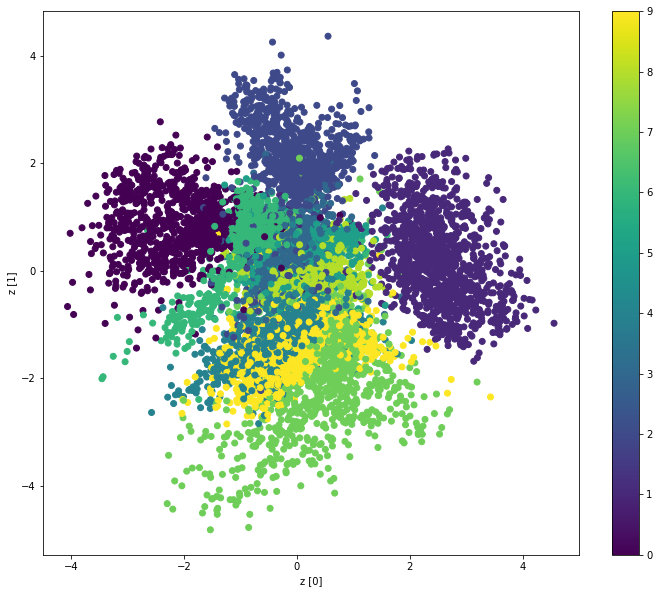

In [8]:
z_mean, _, _ = encoder.predict(X_test,
                               batch_size=batch_size)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z [0]")
plt.ylabel("z [1]")
plt.show()

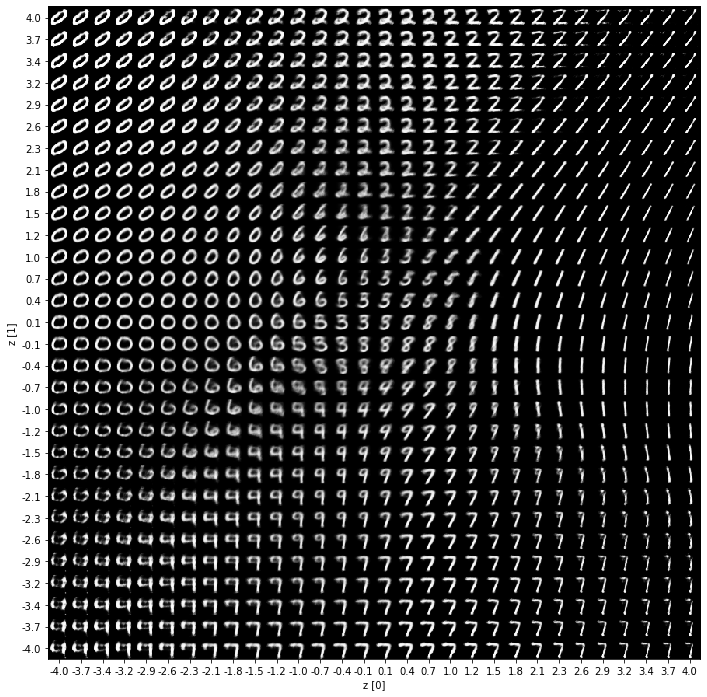

In [9]:
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(12, 12))
start_range = digit_size // 2
end_range = (n - 1) * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z [0]")
plt.ylabel("z [1]")
plt.imshow(figure, cmap='Greys_r')
plt.show()